In [5]:
import numpy as np
import cv2 as cv
from PIL import Image, ImageEnhance
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import matplotlib .pyplot as plt
from itertools import permutations, combinations
import os
import random
import scipy.stats as stats

### MRs

In [3]:
def scale(x, scalar):
    height = int(x.size[0] * scalar)
    width = int(x.size[1] * scalar)
    dim = (width, height)
    return x.resize(dim)

def rotate(x, degree):
    # Rotate the image by degrees counter clockwise
    return x.rotate(degree)

def enh_bri(x, brightness):
    bri = ImageEnhance.Brightness(x)
    return bri.enhance(brightness)

def enh_con(x, contrast):
    con = ImageEnhance.Contrast(x)
    return con.enhance(contrast)

def enh_sha(x, sharpness):
    sha = ImageEnhance.Sharpness(x)
    return sha.enhance(sharpness)

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.GaussianBlur(x, kernel_size, sigmaX=0)
    return Image.fromarray(x)

def shear(x, shear_factor):
    # 定义错切变换矩阵
    shear_matrix = [1, shear_factor, 0, 0, 1, 0]

    # 创建Affine对象并应用错切变换
    sheared_img = x.transform(
        x.size, Image.Transform.AFFINE, shear_matrix
    )
    return sheared_img

def translate(x, shift):
    shift_x, shift_y = shift[0], shift[1]
    # 进行平移操作
    translated_img = x.transform(
        x.size, Image.Transform.AFFINE, (1, 0, shift_x, 0, 1, shift_y)
    )
    return translated_img

mrs = [rotate, enh_bri, enh_sha, enh_con, gaussian, shear, translate]
mrs_name =[mr.__name__ for mr in mrs]
paras = [3, 0.8, 0.8, 0.8, (3, 3), 0.1, (1,1)]

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小以适应预训练模型的输入大小
    transforms.Grayscale(num_output_channels=3),  # 将灰度图像转换为三通道输入
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

batch_size = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

model = models.alexnet()
model.classifier[6] = nn.Linear(4096, 10)
model_name = 'MNIST_AlexNet_9938.pth'
model.load_state_dict(torch.load('./models/'+model_name))
model.eval()
model.to(device)


# correct = 0
# total = 0
# pred_source = np.zeros(len(mnist_testset),dtype=int)
# #pred_source = np.load('predictions/MNIST_AlexNet_9938_source.npy')
# with torch.no_grad():
#     for i,(X,y) in enumerate(test_loader):
#         X,y = X.to(device),y.to(device)
#         outputs = model(X)
#         _, pred = torch.max(outputs, 1)
#         pred_source[i*batch_size:i*batch_size+X.size(0)] = pred.cpu()
#         correct += (pred==y).sum().item()
#         total += y.size(0)

# accuracy = correct/total
# print(accuracy)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

[[14, 15, 4, 13, 68, 64, 87], [25, 18, 19, 75, 67, 120, 25, 26, 48, 155, 66, 105, 18, 26, 20, 75, 61, 94, 19, 48, 20, 134, 65, 99, 83, 152, 75, 131, 121, 152, 62, 66, 61, 65, 120, 263, 107, 105, 94, 100, 152, 252], [37, 56, 156, 69, 126, 37, 33, 89, 69, 116, 57, 33, 137, 68, 125, 155, 89, 140, 124, 163, 69, 68, 68, 124, 298, 126, 116, 125, 163, 324, 37, 56, 156, 69, 126, 38, 56, 200, 73, 108, 56, 54, 494, 98, 128, 168, 200, 492, 229, 255, 67, 71, 98, 228, 279, 113, 108, 128, 256, 273, 38, 34, 90, 69, 123, 38, 56, 197, 74, 108, 34, 55, 168, 69, 107, 91, 198, 170, 127, 157, 65, 74, 69, 134, 262, 115, 108, 107, 157, 259, 57, 33, 137, 68, 125, 57, 55, 493, 98, 130, 33, 56, 168, 68, 108, 147, 491, 169, 204, 231, 65, 98, 69, 201, 274, 107, 130, 108, 230, 266, 164, 93, 149, 125, 168, 164, 198, 490, 230, 255, 95, 197, 170, 127, 156, 149, 491, 170, 205, 230, 123, 230, 128, 205, 349, 157, 255, 156, 230, 344, 67, 65, 65, 125, 276, 67, 71, 98, 228, 279, 64, 74, 68, 135, 262, 65, 98, 69, 202, 274, 

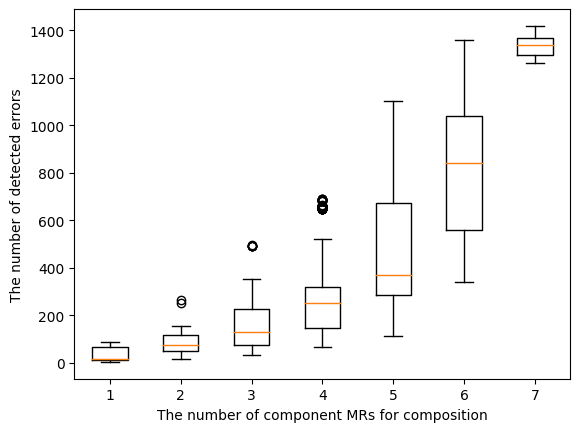

[87, 263, 494, 688, 1102, 1360, 1418]


In [8]:
data = [[] for _ in range(len(mrs))]
pred_source = np.load('predictions/'+model_name.split('.')[0]+'_source.npy')
pred_followup = np.load('predictions/'+model_name.split('.')[0]+'_followup.npy',allow_pickle=True).item()

def error_detection(mr):
    return np.where(pred_followup[mr]!=pred_source)[0]

for mr in pred_followup.keys():
    data[len(mr)-1].append(len(error_detection(mr)))
print(data)

# 创建箱线图
plt.boxplot(data, patch_artist=False)

# 设置图表标题和轴标签
#plt.title('Boxplot Example')
plt.xlabel('The number of component MRs for composition')
plt.ylabel('The number of detected errors')

# 显示图表
plt.show()

print([max(error) for error in data])

In [7]:
errors = [set() for _ in range(len(mrs))]
for mr in pred_followup.keys():
    errors[len(mr)-1].update(error_detection(mr))
print([len(e) for e in errors])
with open('predictions/MNIST_AlexNet9938_error_index.txt', 'w') as f:
    for error in errors:
        error = sorted(list(error))
        f.write(' '.join(map(str, error)) + '\n')

[168, 481, 931, 1354, 1683, 1834, 1736]


In [103]:
errors_all = set()

errors = [set() for _ in range(len(mrs))]
for mr in pred_followup.keys():
    errors[len(mr)-1].update(error_detection(mr))

for error in errors:    
    errors_all.update(error)

t = set()
for i in range(len(errors)):
    t.update(errors[i])
    print(i, len(t)/len(errors_all))

0 0.08235294117647059
1 0.2357843137254902
2 0.4598039215686274
3 0.6720588235294118
4 0.8480392156862745
5 0.9627450980392157
6 1.0


In [16]:
np.save('predictions/'+model_name.split('.')[0]+'_followup.npy', pred_followup)

print(len(pred_followup.keys()))

In [24]:
error_num_diff_ways = [{} for _ in range(len(mrs))]
for i in range(len(mrs)):
    for comb in combinations(range(len(mrs)), i+1):
        #print(comb)
        error_num_diff_ways[i][comb] = []

for p in pred_followup.keys():
    i = len(p)-1
    error_num_diff_ways[i][tuple(sorted(p))].append(len(error_detection(p)))

for i in range(1, len(mrs)-1):
    #print(error_num_diff_ways[i].values())
    f_val, p_val = stats.f_oneway(*error_num_diff_ways[i].values())
    print(i+1, "\tF-value:", f_val, "\tP-value:", p_val)

2 	F-value: 709.1205513785495 	P-value: 2.3741409744438427e-25
3 	F-value: 1356.5409471067549 	P-value: 2.4621139681767148e-194
4 	F-value: 5498.917124231704 	P-value: 0.0
5 	F-value: 35249.35777012918 	P-value: 0.0
6 	F-value: 132531.16345041347 	P-value: 0.0


In [67]:
### 考虑index
error_index_diff_ways = [{} for _ in range(len(mrs))]
for i in range(len(mrs)):
    for comb in combinations(range(len(mrs)), i+1):
        error_index_diff_ways[i][comb] = []

for p in pred_followup.keys():
    i = len(p)-1
    if len(error_detection(p)) != 0:
        error_index_diff_ways[i][tuple(sorted(p))].append(error_detection(p))


In [101]:
### 不同的component有区别，不同方式的区别

def recommand_by_mean(errors, k):
    error_num_dict = {}
    for p in errors.keys():
        error_num_dict[p] = len(errors[p][0])
    sorted_comp = sorted(error_num_dict, key=error_num_dict.get, reverse=True)
    t = ()
    for i in range(k):
        t += sorted_comp[i]
    return tuple(sorted(t))

def recommand_by_union(errors, k):
    error_index_dict = {}
    for comb in combinations(range(len(errors)), k):
        t = set()
        for p in comb:
            t.update(errors[(p,)][0])
        error_index_dict[comb] = len(t)
    sorted_comp = sorted(error_index_dict, key=error_index_dict.get, reverse=True)
    return sorted_comp[0]

def whether_in_topk(errors, comp_mrs):
    mean_dict = {}
    for p in errors.keys():
        t = 0
        for array in errors[p]:
            t += len(array)
        t = t / len(errors[p])
        mean_dict[p] = t
    sorted_comp = sorted(mean_dict, key=mean_dict.get, reverse=True)
    #print(mean_dict,sorted_comp)
    print('Mean:', end='')
    if comp_mrs in sorted_comp[:1]:
        print('Top1')
    elif comp_mrs in sorted_comp[:3]:
        print('Top3')
    elif comp_mrs in sorted_comp[:5]:
        print('Top5')
    elif comp_mrs in sorted_comp[:10]:
        print('Top10')
    else:
        print('XXX')

    print('\tCompared with Top1:', round(mean_dict[comp_mrs] / mean_dict[sorted_comp[0]], 6))
    
    union_dict = {}
    for p in errors.keys():
        t = set()
        for array in errors[p]:
            t.update(array)
        union_dict[p] = len(t)
    sorted_comp = sorted(union_dict, key=union_dict.get, reverse=True)
    print('Union:', end='')
    if comp_mrs in sorted_comp[:1]:
        print('Top1')
    elif comp_mrs in sorted_comp[:3]:
        print('Top3')
    elif comp_mrs in sorted_comp[:5]:
        print('Top5')
    elif comp_mrs in sorted_comp[:10]:
        print('Top10')
    else:
        print('XXX')

    print('\tCompared with Top1:', round(union_dict[comp_mrs] / union_dict[sorted_comp[0]], 6))


for i in range(len(mrs)):
    print('Select component mrs by mean')
    comp_mrs = recommand_by_mean(error_index_diff_ways[0], i+1)
    print(comp_mrs)
    whether_in_topk(error_index_diff_ways[i], comp_mrs)
    print('Select component mrs by union')
    comp_mrs = recommand_by_union(error_index_diff_ways[0], i+1)
    print(comp_mrs)
    whether_in_topk(error_index_diff_ways[i], comp_mrs)
    print('------------------------------------------------------------------')

Select component mrs by mean
(6,)
Mean:Top1
	Compared with Top1: 1.0
Union:Top1
	Compared with Top1: 1.0
Select component mrs by union
(6,)
Mean:Top1
	Compared with Top1: 1.0
Union:Top1
	Compared with Top1: 1.0
------------------------------------------------------------------
Select component mrs by mean
(4, 6)
Mean:Top3
	Compared with Top1: 0.590291
Union:Top3
	Compared with Top1: 0.5
Select component mrs by union
(4, 6)
Mean:Top3
	Compared with Top1: 0.590291
Union:Top3
	Compared with Top1: 0.5
------------------------------------------------------------------
Select component mrs by mean
(4, 5, 6)
Mean:Top3
	Compared with Top1: 0.708573
Union:Top3
	Compared with Top1: 0.852295
Select component mrs by union
(4, 5, 6)
Mean:Top3
	Compared with Top1: 0.708573
Union:Top3
	Compared with Top1: 0.852295
------------------------------------------------------------------
Select component mrs by mean
(1, 4, 5, 6)
Mean:Top5
	Compared with Top1: 0.752978
Union:Top5
	Compared with Top1: 0.860111

In [111]:
### 对于每一维度的cmr选出top10, 看他们的component mrs

error_cmr_diff_ways = [{} for _ in range(len(mrs))]
for cmr in pred_followup:
    error_cmr_diff_ways[len(cmr)-1][cmr] = len(error_detection(cmr))

for i in range(0, len(mrs)):
    sorted_comp = sorted(error_cmr_diff_ways[i], key=error_cmr_diff_ways[i].get, reverse=True)
    top10_perm = sorted_comp[:10]
    top10_comp = [tuple(sorted(perm)) for perm in top10_perm]
    print(top10_perm)
    print(top10_comp)
    print('----------')

[(6,), (4,), (5,), (1,), (0,), (3,), (2,)]
[(6,), (4,), (5,), (1,), (0,), (3,), (2,)]
----------
[(5, 6), (6, 5), (1, 4), (4, 1), (4, 6), (6, 4), (3, 4), (4, 3), (4, 5), (0, 6)]
[(5, 6), (5, 6), (1, 4), (1, 4), (4, 6), (4, 6), (3, 4), (3, 4), (4, 5), (0, 6)]
----------
[(1, 3, 4), (3, 1, 4), (1, 4, 3), (3, 4, 1), (4, 3, 1), (4, 1, 3), (5, 6, 4), (5, 4, 6), (4, 5, 6), (6, 5, 4)]
[(1, 3, 4), (1, 3, 4), (1, 3, 4), (1, 3, 4), (1, 3, 4), (1, 3, 4), (4, 5, 6), (4, 5, 6), (4, 5, 6), (4, 5, 6)]
----------
[(1, 5, 3, 4), (5, 1, 3, 4), (5, 3, 1, 4), (1, 3, 5, 4), (3, 1, 5, 4), (3, 5, 1, 4), (1, 5, 4, 3), (5, 1, 4, 3), (5, 4, 3, 1), (5, 4, 1, 3)]
[(1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5)]
----------
[(3, 1, 4, 5, 6), (4, 5, 6, 3, 1), (5, 3, 1, 4, 6), (3, 1, 5, 4, 6), (3, 1, 5, 6, 4), (3, 5, 1, 4, 6), (3, 5, 1, 6, 4), (3, 5, 6, 1, 4), (4, 3, 1, 5, 6), (4, 3, 5, 1, 6)]
[(1, 3, 4, 5, 6), (1, 3, 4, 5, 6)

In [68]:
### 每个维度计算不同顺序的方差的平均
### 考虑只考虑数量，不考虑error index

mean_standard_deviation = []
mean_relative_standard_deviation = []
for i in range(len(mrs)):
    s = 0
    r_s = 0
    for p in error_num_diff_ways[i].keys():
        s += np.std(error_num_diff_ways[i][p])
        r_s += np.std(error_num_diff_ways[i][p]) / np.mean(error_num_diff_ways[i][p])
    s = s / len(error_num_diff_ways[i].keys())
    r_s = r_s / len(error_num_diff_ways[i].keys())
    mean_standard_deviation.append(s)
    mean_relative_standard_deviation.append(r_s)
print([round(num,4) for num in mean_standard_deviation])
print([round(num,4) for num in mean_relative_standard_deviation])

                                            
mean_p = []
for i in range(1, len(mrs)):
    p_sum = 0
    num = 0
    for mr in error_index_diff_ways[i].keys():
        if len(error_index_diff_ways[i][mr]) > 1:
            num += 1
            #print(error_index_diff_ways[i][mr])
            f_val, p_val = stats.f_oneway(*error_index_diff_ways[i][mr])
            #print(p_val)
            p_sum += p_val
    mean_p.append(p_sum/num)
    #print(num,p_sum)
print(mean_p)

[0.0, 1.0714, 2.9619, 7.3003, 12.1829, 22.5289, 39.865]
[0.0, 0.0094, 0.0192, 0.0284, 0.0299, 0.0312, 0.0299]
[nan, 0.9701257835915472, 0.9959062740644924, 0.9999999805183128, 0.9999999999999014, 0.9999999999999999]


In [104]:
import numpy as np

# 两个 NumPy 数组
array1 = np.array([1, 2, 3, 4, 5])
array2 = np.array([1, 2, 3, 0, 5])

# 比较两个数组，找到不同元素的索引
different_indexes = np.where(array1 != array2)

print("不同元素的索引：", different_indexes)
a = {}


不同元素的索引： (array([3]),)
1
3


In [64]:
print(pred_followup)

a = {}
a['1'] = [1212,1,1]
a['s'] = [2312,2,3]

a.values()

group1 = [1,2,3]
group2 = [3,2,1]

a = [[582,  691, 1039, 1242, 1299, 1681, 2462, 3060, 3451, 3520, 4443,
       4798, 5655, 6553, 6605, 7472, 8527,  9638,9530], [582,  691, 1039, 1242, 1299, 1681, 2462, 3060, 3451, 3520, 4443,
       4798, 5655, 6553, 6605, 7472, 8527, 9530, 9638]]

#a = [[1,2],[1,2]]
f_statistic, p_value = stats.f_oneway(*a)
print(f_statistic, p_value)

{(0,): array([7, 2, 1, ..., 4, 5, 6]), (1,): array([7, 2, 1, ..., 4, 5, 6]), (2,): array([7, 2, 1, ..., 4, 5, 6]), (3,): array([7, 2, 1, ..., 4, 5, 6]), (4,): array([7, 2, 1, ..., 4, 5, 6]), (5,): array([7, 2, 1, ..., 4, 5, 6]), (6,): array([7, 2, 1, ..., 4, 5, 6]), (0, 1): array([7, 2, 1, ..., 4, 5, 6]), (0, 2): array([7, 2, 1, ..., 4, 5, 6]), (0, 3): array([7, 2, 1, ..., 4, 5, 6]), (0, 4): array([7, 2, 1, ..., 4, 5, 6]), (0, 5): array([7, 2, 1, ..., 4, 5, 6]), (0, 6): array([7, 2, 1, ..., 4, 5, 6]), (1, 0): array([7, 2, 1, ..., 4, 5, 6]), (1, 2): array([7, 2, 1, ..., 4, 5, 6]), (1, 3): array([7, 2, 1, ..., 4, 5, 6]), (1, 4): array([7, 2, 1, ..., 4, 5, 6]), (1, 5): array([7, 2, 1, ..., 4, 5, 6]), (1, 6): array([7, 2, 1, ..., 4, 5, 6]), (2, 0): array([7, 2, 1, ..., 4, 5, 6]), (2, 1): array([7, 2, 1, ..., 4, 5, 6]), (2, 3): array([7, 2, 1, ..., 4, 5, 6]), (2, 4): array([7, 2, 1, ..., 4, 5, 6]), (2, 5): array([7, 2, 1, ..., 4, 5, 6]), (2, 6): array([7, 2, 1, ..., 4, 5, 6]), (3, 0): array